In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import random as rdm
import os
np.random.seed(0)
import seaborn as sns
from scipy.optimize import linprog

In [2]:
#problem(1)
Rfunc1 = np.zeros((10,10))
Rfunc1[-1][-1] = 1.0
Rfunc2 = np.zeros((10, 10))
Rfunc2[1:7,4] = -100.0
Rfunc2[1,5] = -100.0
Rfunc2[1:4,6] = Rfunc2[7:9,6] = -100.0
Rfunc2[3,7] = Rfunc2[7,7] = -100.0
Rfunc2[3:8,8] = -100.0
Rfunc2[-1][-1] = 10.0

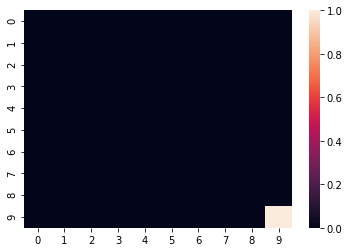

In [3]:
hm1 = sns.heatmap(Rfunc1)

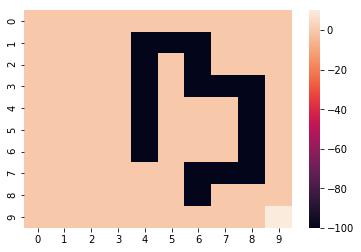

In [4]:
hm2 = sns.heatmap(Rfunc2)

In [5]:
#problem2
width = 10
height = 10
tp = np.zeros((height * width, 5, 4)) # third dimension is direction, last denotes action
#direction to next state 0 : up 1 : right 2 : down 3 : left 4: stay
#action 0 : up 1 : right 2 : down 3 : left
w = 0.1
dx = [0, 1, 0, -1, 0]
dy = [-1, 0, 1, 0, 0]

In [6]:
def isCorner(x, y, height, width):
    return (((y == height - 1) or (y == 0)) and ((x == width - 1) or (x == 0)))
def isEdge(x, y, height, width):
    return (x == 0) or (x == height - 1) or (y == 0) or(y == width - 1)
def offGrid(x, y, height, width):
    return (x < 0) or (x >= height) or (y < 0) or(y >= width)

In [7]:
def cornerSol(x, y, tp, height, width, w):
    state = x * height + y
    for i in range(4): #action
        if(offGrid(x + dx[i], y + dy[i], height, width)):
            for j in range(4):
                if not offGrid(x + dx[j], y + dy[j], height, width):
                    tp[state][j][i] = w / 4.0
            tp[state][4][i] = 1 - w / 2.0
        else:
            for j in range(4):
                if i == j:
                    tp[state][j][i] = 1 - w + w / 4.0
                elif not offGrid(x + dx[j], y + dy[j], height, width):
                    tp[state][j][i] = w / 4.0
            tp[state][4][i] = w / 2.0
            
def edgeSol(x, y, tp, height, width, w):
    state = x * height + y
    for i in range(4): #action
        if(offGrid(x + dx[i], y + dy[i], height, width)):
            for j in range(4):
                if not offGrid(x + dx[j], y + dy[j], height, width):
                    tp[state][j][i] = w / 4.0
            tp[state][4][i] = 1 - w + w / 4.0
        else:
            for j in range(4):
                if i == j:
                    tp[state][j][i] = 1 - w + w / 4.0
                elif not offGrid(x + dx[j], y + dy[j], height, width):
                    tp[state][j][i] = w / 4.0
            tp[state][4][i] = w / 4.0   
            
def innerSol(x, y, tp, height, width, w):
    state = x * height + y
    for i in range(4): # atcion
        for j in range(4):
            if i == j:
                tp[state][j][i] = 1 - w + w / 4.0
            else:
                tp[state][j][i] = w / 4.0

In [8]:
w = 0.1
for i in range(height * width): #calculate transition prob
    x = i // height
    y = i % height
    if isCorner(x, y, height, width):
        cornerSol(x, y, tp, height, width, w)
    elif isEdge(x, y, height, width):
        edgeSol(x, y, tp, height, width, w)
    else:
        innerSol(x, y, tp, height, width, w)

In [9]:
def calStateValue(state, tp, Rfunc, Vs, discount):
    value = np.zeros(4)
    x = state // height
    y = state % height
    for action in range(4):
        for i in range(5):
            x1 = x + dx[i]
            y1 = y + dy[i]
            if offGrid(x1, y1, height, width):
                continue
            state1 = x1 * height + y1
            value[action] += tp[state][i][action] * (Rfunc[y1][x1] + discount * Vs[state1])
    return value
def calVs(Vs, tp, Rfunc, discount, theta):
    while True:
        delta = 0.0
        for s in range(width * height):
            actionValue = calStateValue(s, tp, Rfunc, Vs, discount)
            maxActionValue = max(actionValue)
            delta = max(np.abs(maxActionValue - Vs[s]), delta)
            Vs[s] = maxActionValue
        if delta < theta:
            break

In [10]:
Vs1 = np.zeros(height * width)
discount = 0.8
theta = 0.01
calVs(Vs1, tp, Rfunc1, discount, theta)#calculate state value for each state

In [11]:
from tabulate import tabulate

In [12]:
Vs1_2d = Vs1.reshape((height, width))
print(tabulate(Vs1_2d.T,  tablefmt='fancy_grid'))

╒═══════════╤═══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╕
│ 0.0417957 │ 0.0628379 │ 0.089742 │ 0.123849 │ 0.167081 │ 0.221883 │ 0.291354 │ 0.37942  │ 0.490983 │ 0.609648 │
├───────────┼───────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ 0.0628379 │ 0.0878701 │ 0.121557 │ 0.164514 │ 0.219246 │ 0.28899  │ 0.377871 │ 0.491061 │ 0.633219 │ 0.787354 │
├───────────┼───────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ 0.089742  │ 0.121557  │ 0.16439  │ 0.219132 │ 0.288903 │ 0.377826 │ 0.491156 │ 0.63549  │ 0.817355 │ 1.0186   │
├───────────┼───────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ 0.123849  │ 0.164514  │ 0.219132 │ 0.2889   │ 0.377825 │ 0.491159 │ 0.635601 │ 0.81961  │ 1.05219  │ 1.31506  │
├───────────┼───────────┼──────────┼──────────┼──────────┼──────────┼──────────┼────────

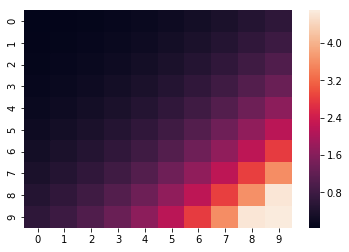

In [13]:
#problem3
hm3 = sns.heatmap(Vs1_2d.T)

In [14]:
#problem5
arrows = ['↑','→','↓','←']
def calOptimalAction(optimalAction, tp, Rfunc, Vs, discount):
    for s in range(height * width):
        actionValue = calStateValue(s, tp, Rfunc, Vs, discount)
        optimal = np.argmax(actionValue)
        optimalAction[s] = optimal
def action2Arrow(action, arrows):
    return [arrows[int(i)] for i in action]

In [15]:
optimalAction1 = np.zeros(height * width)
calOptimalAction(optimalAction1, tp, Rfunc1, Vs1, discount)

In [16]:
optimalAction1_2d = optimalAction1.reshape((height, width))
arrows1 = action2Arrow(optimalAction1, arrows)
path1 = np.array(arrows1).reshape((height,width)).T
print(tabulate(optimalAction1_2d.T,  tablefmt='fancy_grid'))

╒═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╕
│ 2 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 1 │ 1 │ 1 │ 1 │ 1 │ 2 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 1 │ 1 │ 1 │ 2 │ 2 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 1 │ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 1 │ 1 │ 1 │ 1 │ 2 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │
╘═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╛


In [17]:
print(tabulate(path1))

-  -  -  -  -  -  -  -  -  -
↓  →  →  →  →  →  →  ↓  ↓  ↓
↓  →  →  →  →  →  ↓  ↓  ↓  ↓
↓  ↓  →  →  →  ↓  ↓  ↓  ↓  ↓
↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓
↓  ↓  ↓  →  ↓  ↓  ↓  ↓  ↓  ↓
↓  ↓  →  →  →  →  ↓  ↓  ↓  ↓
↓  →  →  →  →  →  →  ↓  ↓  ↓
→  →  →  →  →  →  →  →  ↓  ↓
→  →  →  →  →  →  →  →  →  ↓
→  →  →  →  →  →  →  →  →  →
-  -  -  -  -  -  -  -  -  -


# IRL #

In [18]:
def tp2tpm(height, width, tp):
    tpm = np.zeros((height * width, 4, height * width))
    for s in range(tp.shape[0]):
        x = s // height
        y = s % height
        for action in range(tp.shape[2]):
            for i in range(tp.shape[1]):
                x1 = x + dx[i]
                y1 = y + dy[i]
                if not offGrid(x1, y1, height, width):
                    s1 = x1 * height + y1
                    tpm[s][action][s1] = tp[s][i][action]
    return tpm

In [19]:
def calculate_LP_D(a, s, policy, gamma, tp):
    # (Pa1 −Pa)(I−γPa1)−1
    return np.dot(tp[int(policy[s]), s] - tp[a, s], np.linalg.inv(np.eye(100) - gamma*tp[int(policy[s])]))

In [45]:
def calculate_accuracy(n_states, ground_truth, extracted_reward):
    extracted_reward = extracted_reward.reshape((height,width))
    Vs1 = np.zeros(height * width)
    discount = 0.8
    theta = 0.01
    calVs(Vs1, tp, extracted_reward, discount, theta)
    optimalAction = np.zeros(height * width)
    calOptimalAction(optimalAction, tp, extracted_reward, Vs1, discount)
    count = 0
    for i in range(n_states):
        if ground_truth[i] == optimalAction[i]:
            count += 1
    return float(count)/float(n_states)

In [46]:
#Setting b to be rmax a
import numpy as np
from cvxopt import solvers,matrix
lamda_list = np.linspace(0,5,100)
A = {0,1,2,3}
n_actions = 4
n_states = 100
gamma = 0.8
tpm = tp2tpm(height, width, tp)
print(tpm.shape)
transition_probability = np.transpose(tpm, (1, 0, 2))
# print(transition_probability)
Rmax = Rfunc1.max()
def perform_IRL(optimalAction, transition_probability, Rmax):
    for lamda in lamda_list:
        n_states = 100
        policy = optimalAction
        C = -np.hstack([np.zeros(100), np.ones(100), -lamda*np.ones(100)]) 
#         print(C.shape)   
#         print(A - {policy[1]})
        T_stack = np.vstack([
                calculate_LP_D(a, s, policy, gamma, transition_probability)
                for s in range(n_states)
                for a in A - {policy[s]}
            ])
        one_stack = np.vstack([
                np.eye(1, n_states, s)
                for s in range(n_states)
                for a in A - {policy[s]}
            ])
        # X = [R, T, U, M]
        # (Pa1 −Pa)(I−γPa1)−1 * R >= T => -(Pa1 −Pa)(I−γPa1)−1 * R <= -T => -(Pa1 −Pa)(I−γPa1)−1 * R + T <= 0
        D_0 = np.hstack([-T_stack, one_stack,np.zeros((300,100))])
        # (Pa1 −Pa)(I−γPa1)−1 * R >= 0 => -(Pa1 −Pa)(I−γPa1)−1 * R <= 0
        D_1 = np.hstack([-T_stack, np.zeros((300,100)),np.zeros((300,100))])
        # R <= u and R >= -u => R-u<=0 and -R-u <=0
        D_2 = np.hstack([np.eye(n_states),np.zeros((100,100)),-np.eye(n_states)])
        D_3 = np.hstack([-np.eye(n_states),np.zeros((100,100)),-np.eye(n_states)])
        # R <= Rmax and R >= -Rmax => R - Rmax <=0 and -R - Rmax <=0
        D_4 = np.hstack([np.eye(n_states), np.zeros((100,100)), np.zeros((100,100))])
        D_5 = np.hstack([-np.eye(n_states), np.zeros((100,100)), np.zeros((100,100))])

        D = np.vstack([D_0, D_1, D_2, D_3, D_4, D_5])        
        d = matrix(D)
        B = np.zeros((800, 1))  
        b_bounds = np.vstack([Rmax*np.ones((n_states, 1)), Rmax*np.ones((n_states, 1))])
        B = np.vstack((B, b_bounds))
#         print(B.shape)
#         print(B.shape)
#         print(D.shape)
#         print(C.shape)
        b = matrix(B)
        c = matrix(C)
        results = solvers.lp(c, d, b)
        r = np.asarray(results["x"][:n_states], dtype=np.double)
        # print(r)
        r = r.reshape((n_states,))
        print((r.reshape((n_states,))))
#         if calculate_accuracy(100, optimalAction, r) > 0:
        print(calculate_accuracy(100, optimalAction, r))
    

(100, 4, 100)


In [47]:
perform_IRL(optimalAction1, transition_probability, Rmax)

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8479e+02  2e+03  2e+00  2e+01  1e+00
 1: -1.1131e+01 -1.0568e+02  4e+02  7e-01  5e+00  1e+00
 2: -2.0338e+01 -7.9226e+01  3e+02  5e-01  3e+00  7e-01
 3: -3.0467e+01 -5.9163e+01  1e+02  2e-01  2e+00  3e-01
 4: -3.6246e+01 -4.7375e+01  5e+01  9e-02  6e-01  1e-01
 5: -3.8451e+01 -4.4914e+01  3e+01  5e-02  4e-01  6e-02
 6: -3.9938e+01 -4.2943e+01  1e+01  2e-02  2e-01  3e-02
 7: -4.1140e+01 -4.2248e+01  5e+00  9e-03  6e-02  6e-03
 8: -4.1676e+01 -4.2245e+01  2e+00  4e-03  3e-02  3e-03
 9: -4.2008e+01 -4.2214e+01  9e-01  2e-03  1e-02  1e-03
10: -4.1997e+01 -4.2183e+01  8e-01  1e-03  1e-02  9e-04
11: -4.2097e+01 -4.2143e+01  2e-01  4e-04  3e-03  2e-04
12: -4.2109e+01 -4.2138e+01  1e-01  2e-04  2e-03  1e-04
13: -4.2122e+01 -4.2132e+01  4e-02  8e-05  5e-04  4e-05
14: -4.2124e+01 -4.2130e+01  3e-02  5e-05  3e-04  3e-05
15: -4.2125e+01 -4.2129e+01  2e-02  3e-05  2e-04  2e-05
16: -4.2124e+01 -4.2128e+01  2e-02  3e-05  2e-04  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8479e+02  2e+03  2e+00  2e+01  1e+00
 1: -5.4610e+00 -8.8756e+01  3e+02  7e-01  5e+00  1e+00
 2: -1.2094e+01 -6.4609e+01  2e+02  4e-01  3e+00  7e-01
 3: -1.9736e+01 -4.6971e+01  1e+02  2e-01  1e+00  3e-01
 4: -2.3960e+01 -3.7918e+01  6e+01  1e-01  8e-01  1e-01
 5: -2.7269e+01 -3.3361e+01  2e+01  5e-02  3e-01  6e-02
 6: -2.8777e+01 -3.1989e+01  1e+01  3e-02  2e-01  3e-02
 7: -2.9627e+01 -3.1044e+01  5e+00  1e-02  8e-02  1e-02
 8: -3.0120e+01 -3.0743e+01  2e+00  5e-03  3e-02  4e-03
 9: -3.0327e+01 -3.0532e+01  8e-01  2e-03  1e-02  1e-03
10: -3.0385e+01 -3.0505e+01  5e-01  9e-04  7e-03  6e-04
11: -3.0439e+01 -3.0485e+01  2e-01  4e-04  3e-03  2e-04
12: -3.0447e+01 -3.0477e+01  1e-01  2e-04  2e-03  1e-04
13: -3.0447e+01 -3.0474e+01  1e-01  2e-04  1e-03  1e-04
14: -3.0452e+01 -3.0466e+01  6e-02  1e-04  8e-04  6e-05
15: -3.0456e+01 -3.0464e+01  3e-02  6e-05  4e-04  3e-05
16: -3.0455e+01 -3.0463e+01  3e-02  6e-05  4e-04  

0.62
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8479e+02  2e+03  2e+00  1e+01  1e+00
 1: -2.2615e+00 -7.7550e+01  3e+02  6e-01  4e+00  1e+00
 2: -7.0157e+00 -5.3751e+01  2e+02  4e-01  2e+00  7e-01
 3: -1.1719e+01 -3.7258e+01  1e+02  2e-01  1e+00  3e-01
 4: -1.5814e+01 -2.8047e+01  5e+01  1e-01  6e-01  1e-01
 5: -1.7987e+01 -2.2634e+01  2e+01  4e-02  2e-01  3e-02
 6: -1.9032e+01 -2.1468e+01  9e+00  2e-02  1e-01  1e-02
 7: -1.9890e+01 -2.0613e+01  3e+00  6e-03  4e-02  4e-03
 8: -2.0170e+01 -2.0515e+01  1e+00  3e-03  2e-02  2e-03
 9: -2.0246e+01 -2.0460e+01  8e-01  2e-03  1e-02  9e-04
10: -2.0330e+01 -2.0424e+01  3e-01  7e-04  5e-03  4e-04
11: -2.0356e+01 -2.0409e+01  2e-01  4e-04  3e-03  2e-04
12: -2.0367e+01 -2.0400e+01  1e-01  3e-04  2e-03  1e-04
13: -2.0376e+01 -2.0391e+01  6e-02  1e-04  8e-04  6e-05
14: -2.0381e+01 -2.0387e+01  2e-02  5e-05  3e-04  2e-05
15: -2.0383e+01 -2.0384e+01  4e-03  8e-06  5e-05  4e-06
16: -2.0384e+01 -2.0384e+01  2e-03  3e-06  2e

0.63
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8479e+02  2e+03  2e+00  1e+01  1e+00
 1: -3.3490e-01 -6.8028e+01  2e+02  5e-01  3e+00  1e+00
 2: -3.5257e+00 -4.4035e+01  1e+02  3e-01  2e+00  6e-01
 3: -5.2544e+00 -2.9593e+01  9e+01  2e-01  1e+00  3e-01
 4: -9.0258e+00 -1.8891e+01  3e+01  8e-02  5e-01  1e-01
 5: -1.0365e+01 -1.5840e+01  2e+01  4e-02  3e-01  6e-02
 6: -1.1083e+01 -1.4231e+01  1e+01  2e-02  2e-01  3e-02
 7: -1.1684e+01 -1.2780e+01  4e+00  9e-03  6e-02  8e-03
 8: -1.1985e+01 -1.2395e+01  1e+00  3e-03  2e-02  3e-03
 9: -1.2109e+01 -1.2231e+01  4e-01  1e-03  6e-03  7e-04
10: -1.2148e+01 -1.2182e+01  1e-01  3e-04  2e-03  2e-04
11: -1.2160e+01 -1.2168e+01  3e-02  7e-05  4e-04  3e-05
12: -1.2163e+01 -1.2165e+01  8e-03  2e-05  1e-04  9e-06
13: -1.2163e+01 -1.2164e+01  2e-03  4e-06  3e-05  2e-06
14: -1.2164e+01 -1.2164e+01  5e-04  1e-06  7e-06  5e-07
15: -1.2164e+01 -1.2164e+01  2e-05  5e-08  3e-07  2e-08
16: -1.2164e+01 -1.2164e+01  8e-06  2e-08  1e

0.64
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8479e+02  2e+03  2e+00  1e+01  1e+00
 1:  1.0705e+00 -5.6762e+01  2e+02  5e-01  3e+00  1e+00
 2: -3.6195e-01 -3.1461e+01  1e+02  2e-01  1e+00  5e-01
 3: -3.1186e-01 -1.6542e+01  5e+01  1e-01  8e-01  2e-01
 4: -2.4166e+00 -8.3114e+00  2e+01  5e-02  3e-01  7e-02
 5: -3.3356e+00 -5.2806e+00  6e+00  2e-02  9e-02  1e-02
 6: -3.6770e+00 -4.5342e+00  2e+00  7e-03  4e-02  4e-03
 7: -3.7847e+00 -4.2186e+00  1e+00  3e-03  2e-02  2e-03
 8: -3.8784e+00 -4.0037e+00  4e-01  1e-03  6e-03  4e-04
 9: -3.8968e+00 -3.9709e+00  2e-01  6e-04  3e-03  2e-04
10: -3.9145e+00 -3.9339e+00  5e-02  2e-04  9e-04  6e-05
11: -3.9166e+00 -3.9274e+00  3e-02  8e-05  5e-04  3e-05
12: -3.9194e+00 -3.9208e+00  4e-03  1e-05  7e-05  4e-06
13: -3.9197e+00 -3.9199e+00  8e-04  2e-06  1e-05  8e-07
14: -3.9197e+00 -3.9198e+00  2e-04  6e-07  4e-06  2e-07
15: -3.9197e+00 -3.9198e+00  7e-05  2e-07  1e-06  7e-08
16: -3.9197e+00 -3.9197e+00  2e-05  5e-08  3e

0.65
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8479e+02  2e+03  2e+00  1e+01  1e+00
 1:  1.5995e+00 -5.7479e+01  2e+02  5e-01  3e+00  1e+00
 2:  1.1844e+00 -2.9220e+01  9e+01  2e-01  1e+00  5e-01
 3:  7.2830e-01 -1.2501e+01  4e+01  1e-01  6e-01  2e-01
 4: -2.2616e-02 -4.0519e+00  1e+01  3e-02  2e-01  6e-02
 5: -2.1753e-01 -2.8720e+00  7e+00  2e-02  1e-01  4e-02
 6: -2.8790e-01 -1.8265e+00  4e+00  1e-02  7e-02  2e-02
 7: -4.2950e-01 -9.9866e-01  1e+00  4e-03  2e-02  5e-03
 8: -4.7393e-01 -7.2199e-01  6e-01  2e-03  1e-02  2e-03
 9: -4.9212e-01 -6.5034e-01  4e-01  1e-03  7e-03  8e-04
10: -5.0721e-01 -5.7946e-01  2e-01  6e-04  3e-03  3e-04
11: -5.1114e-01 -5.5708e-01  1e-01  4e-04  2e-03  2e-04
12: -5.1701e-01 -5.2986e-01  3e-02  1e-04  5e-04  5e-05
13: -5.1833e-01 -5.2391e-01  1e-02  4e-05  2e-04  2e-05
14: -5.1888e-01 -5.2064e-01  4e-03  1e-05  8e-05  4e-06
15: -5.1907e-01 -5.1940e-01  8e-04  3e-06  1e-05  8e-07
16: -5.1910e-01 -5.1921e-01  3e-04  9e-07  5e

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8479e+02  2e+03  2e+00  1e+01  1e+00
 1:  2.0236e+00 -6.0122e+01  2e+02  5e-01  2e+00  1e+00
 2:  2.2201e+00 -2.5065e+01  8e+01  2e-01  1e+00  5e-01
 3:  2.4426e+00 -3.9572e+00  2e+01  5e-02  2e-01  5e-02
 4:  7.1903e-01 -8.6141e-01  3e+00  1e-02  6e-02  4e-03
 5:  3.8957e-02 -2.1218e-02  1e-01  5e-04  2e-03  1e-04
 6:  3.9287e-04 -2.1649e-04  1e-03  5e-06  2e-05  1e-06
 7:  3.9284e-06 -2.1647e-06  1e-05  5e-08  2e-07  1e-08
 8:  3.9283e-08 -2.1647e-08  1e-07  5e-10  2e-09  1e-10
 9:  3.9283e-10 -2.1647e-10  1e-09  5e-12  2e-11  1e-12
Optimal solution found.
[-1.05769867e-10 -2.67901938e-11 -7.02391673e-11 -9.43942869e-12
 -3.94062716e-12 -2.97125294e-12 -3.79673405e-13  7.94996719e-13
 -3.81613680e-13  1.75840273e-12 -7.22926718e-11 -7.42365996e-11
 -7.16195648e-11 -8.11538386e-12 -5.24776610e-12 -4.41961532e-13
  4.76990400e-13  3.40140033e-13  2.98203358e-13  3.32660114e-13
 -7.01649366e-11 -6.79502144e-11 -7.1

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8479e+02  2e+03  2e+00  1e+01  1e+00
 1:  2.4188e+00 -6.1173e+01  2e+02  5e-01  2e+00  1e+00
 2:  2.8944e+00 -2.0504e+01  7e+01  2e-01  8e-01  4e-01
 3:  2.4823e+00 -4.4728e+00  2e+01  5e-02  2e-01  6e-02
 4:  3.8573e-01 -3.7388e-01  2e+00  6e-03  3e-02  4e-03
 5:  4.7422e-03 -4.4880e-03  2e-02  7e-05  3e-04  4e-05
 6:  4.7401e-05 -4.4861e-05  2e-04  7e-07  3e-06  4e-07
 7:  4.7401e-07 -4.4861e-07  2e-06  7e-09  3e-08  4e-09
 8:  4.7401e-09 -4.4861e-09  2e-08  7e-11  3e-10  4e-11
Optimal solution found.
[-4.26003322e-10 -1.43814790e-10 -2.57377430e-10 -1.07443701e-10
 -5.27638296e-11 -5.23961678e-11 -1.14713670e-11  2.68629710e-12
 -3.39547154e-12  3.37410185e-11 -3.56320294e-10 -3.62834570e-10
 -3.15906132e-10 -6.85682607e-11 -8.30452862e-11 -7.57054860e-12
  4.28359475e-12 -4.98675948e-13  3.79049951e-13  1.44967113e-12
 -2.12997816e-10 -1.84981325e-10 -2.61153272e-10 -1.61771429e-10
 -1.11088137e-11  3.55064744

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8479e+02  2e+03  2e+00  9e+00  1e+00
 1:  2.8876e+00 -6.2853e+01  2e+02  5e-01  2e+00  1e+00
 2:  3.3189e+00 -1.6825e+01  6e+01  2e-01  6e-01  3e-01
 3:  1.8457e+00 -2.9404e+00  1e+01  4e-02  2e-01  4e-02
 4:  8.9683e-02 -8.3687e-02  4e-01  1e-03  6e-03  9e-04
 5:  8.9722e-04 -8.3965e-04  4e-03  1e-05  6e-05  9e-06
 6:  8.9716e-06 -8.3960e-06  4e-05  1e-07  6e-07  9e-08
 7:  8.9716e-08 -8.3960e-08  4e-07  1e-09  6e-09  9e-10
 8:  8.9716e-10 -8.3960e-10  4e-09  1e-11  6e-11  9e-12
Optimal solution found.
[-4.97153152e-11 -1.66710596e-11 -2.51573478e-11 -1.54406891e-11
 -7.59271635e-12 -7.64556161e-12 -1.56654580e-12  6.48083170e-14
 -4.94225473e-13  4.85816518e-12 -4.87196193e-11 -5.09337720e-11
 -3.94994107e-11 -8.94305033e-12 -1.21137830e-11 -1.13124142e-12
  3.62544922e-13 -3.69750773e-13 -2.41585051e-13 -9.70641154e-14
 -2.13757554e-11 -1.69249625e-11 -2.89563908e-11 -2.69759815e-11
 -1.73698807e-12  3.08418601

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8479e+02  2e+03  2e+00  8e+00  1e+00
 1:  3.4394e+00 -6.5613e+01  3e+02  5e-01  2e+00  1e+00
 2:  3.5383e+00 -1.9504e+01  7e+01  2e-01  7e-01  4e-01
 3:  1.4513e+00 -3.2481e+00  1e+01  4e-02  1e-01  6e-02
 4:  4.8356e-02 -5.6106e-02  2e-01  8e-04  3e-03  7e-04
 5:  4.8302e-04 -5.6080e-04  2e-03  8e-06  3e-05  7e-06
 6:  4.8301e-06 -5.6079e-06  2e-05  8e-08  3e-07  7e-08
 7:  4.8301e-08 -5.6079e-08  2e-07  8e-10  3e-09  7e-10
 8:  4.8301e-10 -5.6079e-10  2e-09  8e-12  3e-11  7e-12
Optimal solution found.
[-1.85606347e-11 -6.55483676e-12 -7.44663669e-12 -6.43393422e-12
 -3.39366168e-12 -3.32811528e-12 -6.63370809e-13  1.48212416e-13
 -3.03773267e-13  2.23454948e-12 -2.15424878e-11 -2.29180415e-11
 -1.65603894e-11 -3.57053334e-12 -5.20158414e-12 -6.01028568e-13
  1.62704490e-13 -1.78347555e-13 -9.95431731e-14  9.07079914e-15
 -8.02920981e-12 -5.90168357e-12 -1.20309922e-11 -1.39537156e-11
 -7.41290091e-13  5.53788174

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8479e+02  2e+03  2e+00  8e+00  1e+00
 1:  4.0821e+00 -6.7025e+01  3e+02  6e-01  2e+00  9e-01
 2:  3.7070e+00 -1.8690e+01  7e+01  2e-01  6e-01  3e-01
 3:  1.1451e+00 -2.3003e+00  8e+00  3e-02  9e-02  4e-02
 4:  2.2328e-02 -3.1333e-02  1e-01  4e-04  1e-03  4e-04
 5:  2.2306e-04 -3.1304e-04  1e-03  4e-06  1e-05  4e-06
 6:  2.2306e-06 -3.1304e-06  1e-05  4e-08  1e-07  4e-08
 7:  2.2306e-08 -3.1304e-08  1e-07  4e-10  1e-09  4e-10
 8:  2.2306e-10 -3.1304e-10  1e-09  4e-12  1e-11  4e-12
Optimal solution found.
[-6.40337015e-12 -2.52755499e-12 -2.35103507e-12 -2.34902299e-12
 -1.37218736e-12 -1.30950368e-12 -3.46202488e-13  1.18969075e-13
 -1.89880305e-13  1.07685970e-12 -8.06609951e-12 -8.60161849e-12
 -6.44823959e-12 -1.37078138e-12 -1.96058807e-12 -3.08946087e-13
  7.35865888e-14 -3.76783526e-14 -3.34536080e-14  7.71515934e-14
 -3.11018895e-12 -2.22546646e-12 -5.04074164e-12 -6.00576340e-12
 -3.84162941e-13 -5.94720415

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8479e+02  2e+03  2e+00  7e+00  1e+00
 1:  4.7779e+00 -6.7388e+01  3e+02  6e-01  2e+00  9e-01
 2:  3.7841e+00 -1.5958e+01  6e+01  2e-01  5e-01  3e-01
 3:  7.7942e-01 -1.1619e+00  5e+00  2e-02  5e-02  2e-02
 4:  1.0205e-02 -1.4308e-02  6e-02  2e-04  6e-04  2e-04
 5:  1.0201e-04 -1.4302e-04  6e-04  2e-06  6e-06  2e-06
 6:  1.0201e-06 -1.4302e-06  6e-06  2e-08  6e-08  2e-08
 7:  1.0201e-08 -1.4302e-08  6e-08  2e-10  6e-10  2e-10
Optimal solution found.
[-2.33306138e-10 -9.52814448e-11 -8.34544554e-11 -8.62291642e-11
 -5.42089768e-11 -5.13181117e-11 -1.67192239e-11  5.31397854e-12
 -8.43327727e-12  5.06458563e-11 -2.95383763e-10 -3.17891363e-10
 -2.54962614e-10 -5.47687537e-11 -7.41558808e-11 -1.44112552e-11
  2.95481636e-12  6.48469264e-13 -4.44906393e-13  4.76453547e-12
 -1.20492394e-10 -8.35962428e-11 -2.09716891e-10 -2.45080413e-10
 -1.90284226e-11 -2.07768852e-12 -2.88262108e-11 -2.37182313e-12
 -1.74256479e-12 -1

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8479e+02  2e+03  2e+00  6e+00  1e+00
 1:  5.4887e+00 -6.6948e+01  3e+02  6e-01  2e+00  9e-01
 2:  3.7304e+00 -1.2044e+01  5e+01  1e-01  4e-01  2e-01
 3:  5.4521e-01 -8.3673e-01  3e+00  1e-02  3e-02  9e-03
 4:  5.9751e-03 -9.0658e-03  4e-02  1e-04  3e-04  1e-04
 5:  5.9737e-05 -9.0636e-05  4e-04  1e-06  3e-06  1e-06
 6:  5.9737e-07 -9.0636e-07  4e-06  1e-08  3e-08  1e-08
 7:  5.9737e-09 -9.0636e-09  4e-08  1e-10  3e-10  1e-10
Optimal solution found.
[-1.10346374e-10 -4.71367363e-11 -4.08089643e-11 -4.23994007e-11
 -2.88302930e-11 -2.67928267e-11 -1.01912860e-11  3.41042514e-12
 -6.30329359e-12  2.95405146e-11 -1.41213347e-10 -1.54600994e-10
 -1.30164539e-10 -3.11588949e-11 -3.78155460e-11 -9.98602207e-12
  1.15312616e-12  4.05434855e-13  3.69882673e-13  5.10564280e-12
 -6.01218022e-11 -4.27662064e-11 -1.05353938e-10 -1.28595909e-10
 -1.35149094e-11 -1.53920993e-12 -1.39223853e-11 -6.37653788e-13
 -4.49254245e-13 -5

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8479e+02  2e+03  2e+00  6e+00  1e+00
 1:  6.1818e+00 -6.5903e+01  3e+02  6e-01  2e+00  8e-01
 2:  3.6865e+00 -1.1129e+01  4e+01  1e-01  3e-01  2e-01
 3:  4.6635e-01 -7.8269e-01  3e+00  1e-02  3e-02  8e-03
 4:  4.8729e-03 -8.1302e-03  3e-02  1e-04  3e-04  9e-05
 5:  4.8720e-05 -8.1287e-05  3e-04  1e-06  3e-06  9e-07
 6:  4.8720e-07 -8.1287e-07  3e-06  1e-08  3e-08  9e-09
 7:  4.8720e-09 -8.1287e-09  3e-08  1e-10  3e-10  9e-11
Optimal solution found.
[-8.02630906e-11 -3.53819693e-11 -3.07656968e-11 -3.12469018e-11
 -2.22779774e-11 -2.04173465e-11 -8.48484005e-12  2.95286696e-12
 -5.57348608e-12  2.48968079e-11 -1.01864612e-10 -1.12901408e-10
 -1.00893411e-10 -2.49919938e-11 -2.83842493e-11 -8.41986873e-12
  6.16357747e-13  5.62306930e-13  6.90271890e-13  5.60664340e-12
 -4.56284131e-11 -3.37147522e-11 -8.29282789e-11 -9.72271046e-11
 -1.20401046e-11 -1.63995194e-12 -1.05672010e-11 -3.68704601e-13
 -1.03285597e-13 -3

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8479e+02  2e+03  2e+00  6e+00  1e+00
 1:  6.8327e+00 -6.4411e+01  3e+02  6e-01  1e+00  8e-01
 2:  3.6291e+00 -1.0785e+01  4e+01  1e-01  3e-01  2e-01
 3:  3.9499e-01 -7.0215e-01  3e+00  9e-03  2e-02  7e-03
 4:  4.0659e-03 -7.2072e-03  3e-02  9e-05  2e-04  7e-05
 5:  4.0653e-05 -7.2062e-05  3e-04  9e-07  2e-06  7e-07
 6:  4.0653e-07 -7.2062e-07  3e-06  9e-09  2e-08  7e-09
 7:  4.0653e-09 -7.2062e-09  3e-08  9e-11  2e-10  7e-11
Optimal solution found.
[-6.11198994e-11 -2.72400310e-11 -2.38354427e-11 -2.39258598e-11
 -1.76130634e-11 -1.60425587e-11 -7.06274510e-12  2.40401205e-12
 -4.81598347e-12  2.08825903e-11 -7.72033997e-11 -8.68329889e-11
 -8.14890784e-11 -2.02316881e-11 -2.21945416e-11 -7.09425522e-12
  2.51283824e-13  4.11038414e-13  6.14776709e-13  5.15735901e-12
 -3.53899130e-11 -2.67112486e-11 -6.72652912e-11 -7.72577363e-11
 -1.05709561e-11 -1.73277597e-12 -9.04961577e-12 -3.94376488e-13
 -9.03723698e-14 -2

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8479e+02  2e+03  2e+00  5e+00  1e+00
 1:  7.4239e+00 -6.2594e+01  3e+02  6e-01  1e+00  8e-01
 2:  3.5324e+00 -1.0321e+01  4e+01  1e-01  3e-01  2e-01
 3:  3.2841e-01 -6.1839e-01  3e+00  7e-03  2e-02  6e-03
 4:  3.3386e-03 -6.2781e-03  3e-02  8e-05  2e-04  6e-05
 5:  3.3382e-05 -6.2774e-05  3e-04  8e-07  2e-06  6e-07
 6:  3.3382e-07 -6.2774e-07  3e-06  8e-09  2e-08  6e-09
 7:  3.3382e-09 -6.2774e-09  3e-08  8e-11  2e-10  6e-11
Optimal solution found.
[-4.66292247e-11 -2.10807040e-11 -1.85411006e-11 -1.84753930e-11
 -1.39433406e-11 -1.26586486e-11 -5.84502167e-12  1.89494001e-12
 -4.12839184e-12  1.72352445e-11 -5.85861771e-11 -6.68161852e-11
 -6.52841233e-11 -1.63411681e-11 -1.75025930e-11 -5.93759469e-12
 -9.80715517e-15  1.45867884e-13  4.31234759e-13  4.53198992e-12
 -2.74018761e-11 -2.10396351e-11 -5.39772226e-11 -6.11458150e-11
 -9.19311910e-12 -1.66288265e-12 -8.01960018e-12 -5.60372547e-13
 -1.50099802e-13 -1

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8479e+02  2e+03  2e+00  5e+00  1e+00
 1:  7.9445e+00 -6.0548e+01  3e+02  5e-01  1e+00  7e-01
 2:  3.3967e+00 -9.7896e+00  4e+01  1e-01  2e-01  2e-01
 3:  2.6828e-01 -5.3600e-01  2e+00  6e-03  1e-02  5e-03
 4:  2.7049e-03 -5.4010e-03  2e-02  6e-05  1e-04  5e-05
 5:  2.7046e-05 -5.4004e-05  2e-04  6e-07  1e-06  5e-07
 6:  2.7046e-07 -5.4004e-07  2e-06  6e-09  1e-08  5e-09
 7:  2.7046e-09 -5.4004e-09  2e-08  6e-11  1e-10  5e-11
Optimal solution found.
[-3.55436464e-11 -1.62982271e-11 -1.43660371e-11 -1.42645832e-11
 -1.09844051e-11 -9.95725420e-12 -4.78611076e-12  1.46477930e-12
 -3.47935095e-12  1.40793877e-11 -4.44748100e-11 -5.13701975e-11
 -5.18554701e-11 -1.31026405e-11 -1.37821588e-11 -4.90393274e-12
 -1.71956200e-13 -6.51653003e-14  2.54310522e-13  3.87921777e-12
 -2.11420814e-11 -1.64385451e-11 -4.28808177e-11 -4.81140482e-11
 -7.89291715e-12 -1.51711880e-12 -7.00283426e-12 -6.94760208e-13
 -2.09480986e-13 -1

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8479e+02  2e+03  2e+00  5e+00  1e+00
 1:  8.3884e+00 -5.8345e+01  3e+02  5e-01  1e+00  7e-01
 2:  3.2235e+00 -9.2204e+00  4e+01  1e-01  2e-01  2e-01
 3:  2.2469e-01 -4.8478e-01  2e+00  6e-03  1e-02  5e-03
 4:  2.2566e-03 -4.8659e-03  2e-02  6e-05  1e-04  5e-05
 5:  2.2564e-05 -4.8655e-05  2e-04  6e-07  1e-06  5e-07
 6:  2.2564e-07 -4.8655e-07  2e-06  6e-09  1e-08  5e-09
 7:  2.2564e-09 -4.8655e-09  2e-08  6e-11  1e-10  5e-11
Optimal solution found.
[-2.78218292e-11 -1.28095184e-11 -1.12542369e-11 -1.11895943e-11
 -8.77089250e-12 -7.95546972e-12 -3.94725331e-12  1.15976900e-12
 -2.93148157e-12  1.17841449e-11 -3.48001866e-11 -4.06946334e-11
 -4.21788132e-11 -1.06651195e-11 -1.10540732e-11 -4.05272542e-12
 -2.49305771e-13 -1.78243575e-13  1.26856925e-13  3.30582290e-12
 -1.66532328e-11 -1.30187556e-11 -3.49022975e-11 -3.88587892e-11
 -6.90751380e-12 -1.37366785e-12 -6.10855568e-12 -7.95479906e-13
 -2.77769313e-13 -1

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8479e+02  2e+03  2e+00  4e+00  1e+00
 1:  8.7532e+00 -5.6041e+01  3e+02  5e-01  1e+00  7e-01
 2:  3.0148e+00 -8.6314e+00  4e+01  9e-02  2e-01  1e-01
 3:  1.8352e-01 -4.2412e-01  2e+00  5e-03  9e-03  4e-03
 4:  1.8380e-03 -4.2456e-03  2e-02  5e-05  9e-05  4e-05
 5:  1.8379e-05 -4.2453e-05  2e-04  5e-07  9e-07  4e-07
 6:  1.8379e-07 -4.2453e-07  2e-06  5e-09  9e-09  4e-09
 7:  1.8379e-09 -4.2453e-09  2e-08  5e-11  9e-11  4e-11
Optimal solution found.
[-2.12325074e-11 -9.77867396e-12 -8.54459050e-12 -8.51846886e-12
 -6.78277098e-12 -6.16277211e-12 -3.13966299e-12  8.95667922e-13
 -2.37216242e-12  9.60592076e-12 -2.66606443e-11 -3.15457788e-11
 -3.34137538e-11 -8.42104147e-12 -8.60813965e-12 -3.23902021e-12
 -2.60890450e-13 -2.16129453e-13  4.93568025e-14  2.70965274e-12
 -1.27671031e-11 -1.00024040e-11 -2.76007774e-11 -3.06516317e-11
 -5.83639117e-12 -1.20927173e-12 -5.06749507e-12 -7.84125342e-13
 -3.01406471e-13 -9

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8479e+02  2e+03  2e+00  4e+00  1e+00
 1:  9.0391e+00 -5.3677e+01  3e+02  5e-01  9e-01  6e-01
 2:  2.7725e+00 -8.0330e+00  4e+01  9e-02  2e-01  1e-01
 3:  1.4468e-01 -3.5577e-01  2e+00  4e-03  7e-03  4e-03
 4:  1.4465e-03 -3.5556e-03  2e-02  4e-05  7e-05  4e-05
 5:  1.4464e-05 -3.5554e-05  2e-04  4e-07  7e-07  4e-07
 6:  1.4464e-07 -3.5554e-07  2e-06  4e-09  7e-09  4e-09
 7:  1.4464e-09 -3.5554e-09  2e-08  4e-11  7e-11  4e-11
Optimal solution found.
[-1.56176983e-11 -7.17453570e-12 -6.22741400e-12 -6.22419827e-12
 -5.02423823e-12 -4.57622737e-12 -2.38257949e-12  6.67965515e-13
 -1.82494490e-12  7.54011909e-12 -1.97646606e-11 -2.36612486e-11
 -2.55432383e-11 -6.38262744e-12 -6.43541923e-12 -2.47781355e-12
 -2.26454619e-13 -2.03556875e-13  1.33830365e-14  2.10852219e-12
 -9.42346662e-12 -7.38451285e-12 -2.10109493e-11 -2.33786874e-11
 -4.71274713e-12 -1.01862637e-12 -3.98131371e-12 -6.89035416e-13
 -2.85393890e-13 -8

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8479e+02  2e+03  2e+00  4e+00  1e+00
 1:  9.2484e+00 -5.1285e+01  3e+02  5e-01  8e-01  6e-01
 2:  2.4977e+00 -7.4302e+00  3e+01  8e-02  1e-01  1e-01
 3:  1.0903e-01 -2.8408e-01  1e+00  3e-03  5e-03  3e-03
 4:  1.0893e-03 -2.8373e-03  1e-02  3e-05  5e-05  3e-05
 5:  1.0893e-05 -2.8372e-05  1e-04  3e-07  5e-07  3e-07
 6:  1.0893e-07 -2.8372e-07  1e-06  3e-09  5e-09  3e-09
 7:  1.0893e-09 -2.8372e-09  1e-08  3e-11  5e-11  3e-11
Optimal solution found.
[-1.09477273e-11 -5.00570118e-12 -4.31506313e-12 -4.31739487e-12
 -3.52399713e-12 -3.21904624e-12 -1.70428280e-12  4.75256516e-13
 -1.31791613e-12  5.63149432e-12 -1.40149992e-11 -1.69845100e-11
 -1.86673262e-11 -4.59199773e-12 -4.56656163e-12 -1.79332164e-12
 -1.64280445e-13 -1.63679506e-13  8.39941022e-15  1.52965444e-12
 -6.62204611e-12 -5.18479822e-12 -1.52518077e-11 -1.70705023e-11
 -3.59898243e-12 -8.05631639e-13 -2.94522583e-12 -5.43770638e-13
 -2.39281061e-13 -6

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8479e+02  2e+03  2e+00  4e+00  1e+00
 1:  9.3913e+00 -4.8996e+01  3e+02  5e-01  8e-01  6e-01
 2:  2.2276e+00 -7.0048e+00  3e+01  7e-02  1e-01  1e-01
 3:  8.2763e-02 -2.2938e-01  1e+00  2e-03  4e-03  2e-03
 4:  8.2665e-04 -2.2907e-03  1e-02  2e-05  4e-05  2e-05
 5:  8.2663e-06 -2.2906e-05  1e-04  2e-07  4e-07  2e-07
 6:  8.2663e-08 -2.2906e-07  1e-06  2e-09  4e-09  2e-09
 7:  8.2663e-10 -2.2906e-09  1e-08  2e-11  4e-11  2e-11
Optimal solution found.
[-7.81224274e-12 -3.57843456e-12 -3.06802389e-12 -3.06259125e-12
 -2.51965818e-12 -2.30743285e-12 -1.23888588e-12  3.41524610e-13
 -9.66641343e-13  4.24838552e-12 -1.01034633e-11 -1.23710562e-11
 -1.38078878e-11 -3.36463038e-12 -3.29997113e-12 -1.32590809e-12
 -1.12399895e-13 -1.31080069e-13  1.00742799e-14  1.10251210e-12
 -4.75096103e-12 -3.72440613e-12 -1.12106169e-11 -1.26463507e-11
 -2.75227041e-12 -6.51636789e-13 -2.19315662e-12 -4.18510653e-13
 -1.96536544e-13 -5

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8479e+02  2e+03  2e+00  4e+00  1e+00
 1:  9.5033e+00 -4.7272e+01  3e+02  4e-01  7e-01  6e-01
 2:  2.0236e+00 -6.8821e+00  3e+01  7e-02  1e-01  1e-01
 3:  6.6824e-02 -1.9790e-01  9e-01  2e-03  3e-03  2e-03
 4:  6.6749e-04 -1.9765e-03  9e-03  2e-05  3e-05  2e-05
 5:  6.6747e-06 -1.9764e-05  9e-05  2e-07  3e-07  2e-07
 6:  6.6747e-08 -1.9764e-07  9e-07  2e-09  3e-09  2e-09
 7:  6.6747e-10 -1.9764e-09  9e-09  2e-11  3e-11  2e-11
Optimal solution found.
[-6.04220991e-12 -2.80616335e-12 -2.39451129e-12 -2.37865510e-12
 -1.96873874e-12 -1.80562844e-12 -9.84375959e-13  2.63143730e-13
 -7.78741318e-13  3.44511288e-12 -7.85523302e-12 -9.67965508e-12
 -1.09330857e-11 -2.68355940e-12 -2.59453105e-12 -1.07228706e-12
 -9.31635931e-14 -1.16332645e-13  1.01417395e-15  8.64729470e-13
 -3.71599292e-12 -2.92716239e-12 -8.84835331e-12 -1.00467346e-11
 -2.23491383e-12 -5.81771919e-13 -1.74290588e-12 -3.49171099e-13
 -1.77439159e-13 -4

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8479e+02  2e+03  2e+00  3e+00  1e+00
 1:  9.5508e+00 -4.5549e+01  3e+02  4e-01  7e-01  5e-01
 2:  1.7943e+00 -6.7143e+00  3e+01  7e-02  1e-01  9e-02
 3:  5.2110e-02 -1.6551e-01  7e-01  2e-03  3e-03  2e-03
 4:  5.2054e-04 -1.6531e-03  7e-03  2e-05  3e-05  2e-05
 5:  5.2053e-06 -1.6531e-05  7e-05  2e-07  3e-07  2e-07
 6:  5.2053e-08 -1.6531e-07  7e-07  2e-09  3e-09  2e-09
 7:  5.2053e-10 -1.6531e-09  7e-09  2e-11  3e-11  2e-11
Optimal solution found.
[-4.55932282e-12 -2.15215963e-12 -1.83095774e-12 -1.80556857e-12
 -1.49751022e-12 -1.37399487e-12 -7.56493482e-13  1.97709080e-13
 -6.02678947e-13  2.70859974e-12 -5.94973559e-12 -7.36766508e-12
 -8.40414634e-12 -2.07843697e-12 -1.98323738e-12 -8.37901749e-13
 -6.77333816e-14 -9.37743087e-14  3.20558366e-15  6.53481017e-13
 -2.83650035e-12 -2.24707166e-12 -6.78573988e-12 -7.74390950e-12
 -1.74690953e-12 -4.92224554e-13 -1.31595695e-12 -2.73240979e-13
 -1.46798443e-13 -3

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8479e+02  2e+03  2e+00  3e+00  1e+00
 1:  9.5355e+00 -4.3879e+01  3e+02  4e-01  6e-01  5e-01
 2:  1.5390e+00 -6.5081e+00  3e+01  6e-02  9e-02  9e-02
 3:  3.8870e-02 -1.3338e-01  6e-01  1e-03  2e-03  1e-03
 4:  3.8832e-04 -1.3324e-03  6e-03  1e-05  2e-05  1e-05
 5:  3.8832e-06 -1.3324e-05  6e-05  1e-07  2e-07  1e-07
 6:  3.8832e-08 -1.3324e-07  6e-07  1e-09  2e-09  1e-09
 7:  3.8832e-10 -1.3324e-09  6e-09  1e-11  2e-11  1e-11
Optimal solution found.
[-3.33543047e-12 -1.60469478e-12 -1.36564114e-12 -1.33283233e-12
 -1.10213601e-12 -1.00986795e-12 -5.57649829e-13  1.43750585e-13
 -4.43560352e-13  2.04609029e-12 -4.36008257e-12 -5.41869048e-12
 -6.23128609e-12 -1.55080763e-12 -1.46343529e-12 -6.28420240e-13
 -3.90563231e-14 -6.93128898e-14  1.22694753e-14  4.69079652e-13
 -2.09857342e-12 -1.67404359e-12 -5.02126382e-12 -5.75374230e-12
 -1.30057702e-12 -3.91448299e-13 -9.39687464e-13 -1.96833037e-13
 -1.09251341e-13 -2

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8479e+02  2e+03  2e+00  3e+00  1e+00
 1:  9.3833e+00 -4.4261e+01  3e+02  4e-01  6e-01  5e-01
 2:  1.4779e+00 -6.4423e+00  3e+01  6e-02  9e-02  8e-02
 3:  3.5358e-02 -1.3006e-01  6e-01  1e-03  2e-03  1e-03
 4:  3.5324e-04 -1.2992e-03  6e-03  1e-05  2e-05  1e-05
 5:  3.5324e-06 -1.2992e-05  6e-05  1e-07  2e-07  1e-07
 6:  3.5324e-08 -1.2992e-07  6e-07  1e-09  2e-09  1e-09
 7:  3.5324e-10 -1.2992e-09  6e-09  1e-11  2e-11  1e-11
Optimal solution found.
[-3.04967302e-12 -1.49446869e-12 -1.26646724e-12 -1.23287867e-12
 -1.02319555e-12 -9.37548021e-13 -5.22727213e-13  1.33772016e-13
 -4.17269877e-13  1.92989973e-12 -3.96043482e-12 -4.90282195e-12
 -5.63198272e-12 -1.45335472e-12 -1.35818740e-12 -5.92599635e-13
 -4.39380304e-14 -6.09653407e-14  7.02350528e-15  4.52991612e-13
 -1.94109880e-12 -1.55457094e-12 -4.57948355e-12 -5.19234861e-12
 -1.22502661e-12 -3.88011579e-13 -8.23504600e-13 -1.86813311e-13
 -1.05608795e-13 -2

In [23]:
#problem6
Vs2 = np.zeros(height * width)
calVs(Vs2, tp, Rfunc2, discount, theta)#calculate state value for each state

In [24]:
Vs2_2d = Vs2.reshape((height, width))
print(tabulate(Vs2_2d.T,  tablefmt='fancy_grid'))

╒══════════╤══════════╤══════════╤════════════╤══════════╤════════════╤═══════════╤══════════╤═══════════╤══════════╕
│ 0.648477 │ 0.794107 │ 0.825238 │  0.536246  │ -2.37043 │  -4.23382  │ -1.92053  │  1.13111 │  1.59436  │  2.03821 │
├──────────┼──────────┼──────────┼────────────┼──────────┼────────────┼───────────┼──────────┼───────────┼──────────┤
│ 0.829852 │ 1.02124  │ 1.06603  │ -1.8679    │ -6.73822 │  -8.67375  │ -6.36979  │ -1.2948  │  1.92834  │  2.61047 │
├──────────┼──────────┼──────────┼────────────┼──────────┼────────────┼───────────┼──────────┼───────────┼──────────┤
│ 1.06361  │ 1.31651  │ 1.45008  │ -1.62403   │ -6.74151 │ -13.9112   │ -9.64923  │ -5.51104 │ -0.131013 │  3.35906 │
├──────────┼──────────┼──────────┼────────────┼──────────┼────────────┼───────────┼──────────┼───────────┼──────────┤
│ 1.36025  │ 1.6927   │ 1.94802  │ -1.23217   │ -6.32308 │  -7.97761  │ -7.93668  │ -9.42387 │ -1.91443  │  4.39063 │
├──────────┼──────────┼──────────┼────────────┼─────────

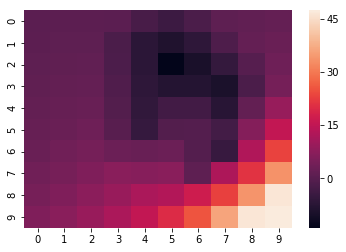

In [25]:
#problem7
hm4 = sns.heatmap(Vs2_2d.T)

In [26]:
#problem9
optimalAction2 = np.zeros(height * width)
calOptimalAction(optimalAction2, tp, Rfunc2, Vs2, discount)

In [27]:
optimalAction2_2d = optimalAction2.reshape((height, width))
arrows2 = action2Arrow(optimalAction2, arrows)
path2 = np.array(arrows2).reshape((height,width)).T
print(tabulate(optimalAction2_2d.T,  tablefmt='fancy_grid'))

╒═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╕
│ 2 │ 2 │ 2 │ 3 │ 3 │ 1 │ 1 │ 1 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 3 │ 3 │ 0 │ 1 │ 1 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 3 │ 3 │ 2 │ 1 │ 1 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 3 │ 3 │ 2 │ 2 │ 0 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 3 │ 3 │ 2 │ 2 │ 2 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 3 │ 3 │ 2 │ 2 │ 3 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │ 3 │ 3 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │ 3 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 1 │ 1 │ 1 │ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │
╘═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╛


In [28]:
print(tabulate(path2))

-  -  -  -  -  -  -  -  -  -
↓  ↓  ↓  ←  ←  →  →  →  →  ↓
↓  ↓  ↓  ←  ←  ↑  →  →  →  ↓
↓  ↓  ↓  ←  ←  ↓  →  →  →  ↓
↓  ↓  ↓  ←  ←  ↓  ↓  ↑  →  ↓
↓  ↓  ↓  ←  ←  ↓  ↓  ↓  →  ↓
↓  ↓  ↓  ←  ←  ↓  ↓  ←  →  ↓
↓  ↓  ↓  ↓  ↓  ↓  ←  ←  →  ↓
↓  ↓  ↓  ↓  ↓  ↓  ←  ↓  ↓  ↓
→  →  →  ↓  ↓  ↓  ↓  ↓  ↓  ↓
→  →  →  →  →  →  →  →  →  →
-  -  -  -  -  -  -  -  -  -


In [40]:
# tpm = tp2tpm(height, width, tp)
# print(tpm.shape)
# transition_probability = np.transpose(tpm, (1, 0, 2))
# print(transition_probability)
Rmax = Rfunc2.max()
perform_IRL(optimalAction2, transition_probability, Rmax)


     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  2e+01  1e+00
 1:  3.2585e+00 -1.1221e+03  2e+03  9e-02  8e+00  8e-01
 2: -3.4423e+01 -6.8431e+02  1e+03  5e-02  5e+00  7e-01
 3: -1.3348e+02 -4.7421e+02  8e+02  3e-02  2e+00  6e-01
 4: -2.6412e+02 -5.5468e+02  9e+02  2e-02  2e+00  6e-01
 5: -3.3301e+02 -5.6734e+02  9e+02  2e-02  2e+00  6e-01
 6: -4.3662e+02 -5.6416e+02  6e+02  1e-02  9e-01  4e-01
 7: -4.5898e+02 -5.4369e+02  4e+02  7e-03  6e-01  3e-01
 8: -5.0518e+02 -5.4344e+02  2e+02  3e-03  3e-01  2e-01
 9: -5.2242e+02 -5.4582e+02  1e+02  2e-03  2e-01  1e-01
10: -5.3535e+02 -5.4714e+02  6e+01  9e-04  8e-02  6e-02
11: -5.4424e+02 -5.4961e+02  3e+01  4e-04  4e-02  3e-02
12: -5.5033e+02 -5.5154e+02  6e+00  1e-04  9e-03  6e-03
13: -5.5066e+02 -5.5159e+02  5e+00  8e-05  7e-03  5e-03
14: -5.5129e+02 -5.5174e+02  2e+00  4e-05  3e-03  2e-03
15: -5.5182e+02 -5.5188e+02  3e-01  5e-06  4e-04  3e-04
16: -5.5188e+02 -5.5190e+02  8e-02  1e-06  1e-04  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  2e+01  1e+00
 1:  3.0837e+01 -1.0154e+03  2e+03  8e-02  7e+00  7e-01
 2:  1.5723e+01 -5.9236e+02  1e+03  5e-02  4e+00  6e-01
 3: -3.0502e+01 -2.7992e+02  4e+02  2e-02  2e+00  4e-01
 4: -9.5762e+01 -3.2096e+02  6e+02  2e-02  2e+00  4e-01
 5: -1.3737e+02 -3.3300e+02  6e+02  2e-02  1e+00  4e-01
 6: -1.8008e+02 -3.2677e+02  5e+02  1e-02  1e+00  3e-01
 7: -2.2728e+02 -3.1573e+02  3e+02  7e-03  6e-01  2e-01
 8: -2.4613e+02 -3.0947e+02  2e+02  5e-03  4e-01  2e-01
 9: -2.8026e+02 -3.0704e+02  1e+02  2e-03  2e-01  8e-02
10: -2.9485e+02 -3.0706e+02  5e+01  1e-03  8e-02  4e-02
11: -3.0387e+02 -3.0707e+02  1e+01  3e-04  2e-02  1e-02
12: -3.0623e+02 -3.0733e+02  4e+00  9e-05  8e-03  4e-03
13: -3.0711e+02 -3.0746e+02  1e+00  3e-05  2e-03  1e-03
14: -3.0747e+02 -3.0754e+02  3e-01  6e-06  5e-04  3e-04
15: -3.0753e+02 -3.0755e+02  9e-02  2e-06  1e-04  8e-05
16: -3.0755e+02 -3.0755e+02  7e-03  1e-07  1e-05  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  2e+01  1e+00
 1:  4.7189e+01 -1.0024e+03  2e+03  8e-02  6e+00  7e-01
 2:  4.1356e+01 -5.6767e+02  9e+02  5e-02  4e+00  6e-01
 3:  1.2197e+01 -2.2538e+02  4e+02  2e-02  1e+00  3e-01
 4: -2.9234e+00 -1.6705e+02  3e+02  1e-02  1e+00  2e-01
 5: -4.3097e+01 -1.3424e+02  2e+02  7e-03  5e-01  2e-01
 6: -4.4212e+01 -1.3371e+02  2e+02  7e-03  5e-01  2e-01
 7: -6.2711e+01 -1.3501e+02  2e+02  6e-03  4e-01  2e-01
 8: -7.2307e+01 -1.2538e+02  2e+02  4e-03  3e-01  1e-01
 9: -8.9644e+01 -1.1960e+02  1e+02  2e-03  2e-01  8e-02
10: -1.0523e+02 -1.1754e+02  4e+01  1e-03  7e-02  4e-02
11: -1.1124e+02 -1.1791e+02  2e+01  5e-04  4e-02  2e-02
12: -1.1167e+02 -1.1771e+02  2e+01  5e-04  4e-02  2e-02
13: -1.1437e+02 -1.1782e+02  1e+01  3e-04  2e-02  1e-02
14: -1.1672e+02 -1.1795e+02  4e+00  1e-04  7e-03  4e-03
15: -1.1734e+02 -1.1798e+02  2e+00  5e-05  4e-03  2e-03
16: -1.1776e+02 -1.1801e+02  9e-01  2e-05  2e-03  

20: -9.9158e+00 -9.9280e+00  3e-02  1e-06  6e-05  3e-05
21: -9.9214e+00 -9.9260e+00  1e-02  4e-07  2e-05  1e-05
22: -9.9242e+00 -9.9248e+00  1e-03  4e-08  3e-06  1e-06
23: -9.9246e+00 -9.9246e+00  2e-05  7e-10  5e-08  2e-08
24: -9.9246e+00 -9.9246e+00  5e-06  1e-10  9e-09  5e-09
Optimal solution found.
0.03
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  1e+01  1e+00
 1:  5.7047e+01 -9.9710e+02  2e+03  8e-02  5e+00  7e-01
 2:  5.8637e+01 -5.6914e+02  9e+02  5e-02  3e+00  6e-01
 3:  3.0307e+01 -1.7546e+02  3e+02  2e-02  1e+00  2e-01
 4:  1.4934e+01 -4.5443e+01  9e+01  5e-03  3e-01  8e-02
 5:  1.0090e+01 -2.3549e+01  5e+01  3e-03  2e-01  5e-02
 6:  3.5034e+00 -5.8728e+00  1e+01  8e-04  5e-02  1e-02
 7:  1.5329e+00 -2.2577e+00  6e+00  3e-04  2e-02  6e-03
 8:  1.0040e+00 -9.8932e-01  3e+00  2e-04  1e-02  3e-03
 9:  3.7623e-01 -1.7458e-01  8e-01  4e-05  3e-03  9e-04
10:  7.1489e-02 -1.9196e-02  1e-01  7e-06  4e-04  9e-05
11:  2.5018e-03 -6.75

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  1e+01  1e+00
 1:  6.5651e+01 -9.9465e+02  2e+03  8e-02  4e+00  7e-01
 2:  7.7814e+01 -5.6958e+02  1e+03  5e-02  2e+00  6e-01
 3:  5.0830e+01 -1.5142e+02  3e+02  2e-02  7e-01  2e-01
 4:  1.4109e+01 -1.4328e+01  3e+01  2e-03  1e-01  3e-02
 5:  5.2331e-01 -2.3473e-01  9e-01  6e-05  3e-03  8e-04
 6:  5.2261e-03 -2.3442e-03  9e-03  6e-07  3e-05  8e-06
 7:  5.2260e-05 -2.3441e-05  9e-05  6e-09  3e-07  8e-08
 8:  5.2260e-07 -2.3441e-07  9e-07  6e-11  3e-09  8e-10
 9:  5.2260e-09 -2.3441e-09  9e-09  6e-13  3e-11  8e-12
Optimal solution found.
0.02
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  1e+01  1e+00
 1:  6.6068e+01 -9.9465e+02  2e+03  8e-02  4e+00  7e-01
 2:  7.9012e+01 -5.6916e+02  1e+03  5e-02  2e+00  6e-01
 3:  5.2049e+01 -1.5041e+02  3e+02  2e-02  7e-01  2e-01
 4:  1.3555e+01 -1.2500e+01  3e+01  2e-03  9e-02  3e-02
 5:  3.9615e-01 -1.7268

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  8e+00  1e+00
 1:  6.8955e+01 -9.9559e+02  2e+03  9e-02  3e+00  7e-01
 2:  9.0535e+01 -5.5983e+02  1e+03  5e-02  2e+00  6e-01
 3:  6.2913e+01 -1.3566e+02  3e+02  2e-02  6e-01  2e-01
 4:  9.6893e+00 -8.4258e+00  2e+01  1e-03  5e-02  2e-02
 5:  1.1986e-01 -8.9120e-02  2e-01  2e-05  6e-04  2e-04
 6:  1.1981e-03 -8.9087e-04  2e-03  2e-07  6e-06  2e-06
 7:  1.1981e-05 -8.9086e-06  2e-05  2e-09  6e-08  2e-08
 8:  1.1981e-07 -8.9086e-08  2e-07  2e-11  6e-10  2e-10
 9:  1.1981e-09 -8.9086e-10  2e-09  2e-13  6e-12  2e-12
Optimal solution found.
0.02
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  8e+00  1e+00
 1:  6.9063e+01 -9.9571e+02  2e+03  9e-02  3e+00  7e-01
 2:  9.1313e+01 -5.5874e+02  1e+03  5e-02  2e+00  6e-01
 3:  6.3579e+01 -1.3428e+02  3e+02  2e-02  6e-01  3e-01
 4:  9.3410e+00 -8.1527e+00  2e+01  1e-03  5e-02  2e-02
 5:  1.1186e-01 -8.5575

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  6e+00  1e+00
 1:  6.9391e+01 -9.9711e+02  2e+03  9e-02  2e+00  6e-01
 2:  9.9222e+01 -5.4281e+02  1e+03  5e-02  1e+00  6e-01
 3:  6.9796e+01 -1.1877e+02  3e+02  2e-02  4e-01  3e-01
 4:  5.5029e+00 -3.2400e+00  1e+01  7e-04  2e-02  1e-02
 5:  5.5853e-02 -3.2974e-02  1e-01  7e-06  2e-04  1e-04
 6:  5.5845e-04 -3.2970e-04  1e-03  7e-08  2e-06  1e-06
 7:  5.5845e-06 -3.2970e-06  1e-05  7e-10  2e-08  1e-08
 8:  5.5845e-08 -3.2970e-08  1e-07  7e-12  2e-10  1e-10
 9:  5.5845e-10 -3.2970e-10  1e-09  7e-14  2e-12  1e-12
Optimal solution found.
0.02
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  6e+00  1e+00
 1:  6.9357e+01 -9.9721e+02  2e+03  9e-02  2e+00  6e-01
 2:  9.9786e+01 -5.4130e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.0239e+01 -1.1824e+02  3e+02  2e-02  4e-01  3e-01
 4:  5.3115e+00 -3.0364e+00  1e+01  7e-04  2e-02  1e-02
 5:  5.3781e-02 -3.0849

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  5e+00  1e+00
 1:  6.8424e+01 -9.9803e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0617e+02 -5.1994e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.4359e+01 -1.0549e+02  3e+02  1e-02  3e-01  3e-01
 4:  4.0913e+00 -2.7695e+00  9e+00  5e-04  1e-02  9e-03
 5:  4.1120e-02 -2.7865e-02  9e-02  6e-06  1e-04  9e-05
 6:  4.1117e-04 -2.7862e-04  9e-04  6e-08  1e-06  9e-07
 7:  4.1117e-06 -2.7862e-06  9e-06  6e-10  1e-08  9e-09
 8:  4.1117e-08 -2.7862e-08  9e-08  6e-12  1e-10  9e-11
Optimal solution found.
0.02
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  5e+00  1e+00
 1:  6.8325e+01 -9.9805e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0661e+02 -5.1821e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.4572e+01 -1.0413e+02  3e+02  1e-02  3e-01  3e-01
 4:  3.9916e+00 -2.7312e+00  8e+00  5e-04  1e-02  9e-03
 5:  4.0093e-02 -2.7460e-02  8e-02  5e-06  1e-04  9e-05
 6:  4.0090e-04 -2.7458

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  4e+00  1e+00
 1:  6.6830e+01 -9.9777e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0978e+02 -5.1546e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.3968e+01 -9.6654e+01  2e+02  1e-02  3e-01  3e-01
 4:  3.4947e+00 -2.3745e+00  8e+00  5e-04  9e-03  9e-03
 5:  3.4928e-02 -2.3749e-02  8e-02  5e-06  9e-05  9e-05
 6:  3.4927e-04 -2.3748e-04  8e-04  5e-08  9e-07  9e-07
 7:  3.4927e-06 -2.3748e-06  8e-06  5e-10  9e-09  9e-09
 8:  3.4927e-08 -2.3748e-08  8e-08  5e-12  9e-11  9e-11
Optimal solution found.
0.02
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  4e+00  1e+00
 1:  6.6705e+01 -9.9770e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0992e+02 -5.1575e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.3859e+01 -9.7544e+01  2e+02  1e-02  3e-01  3e-01
 4:  3.2826e+00 -2.2837e+00  7e+00  4e-04  9e-03  8e-03
 5:  3.2798e-02 -2.2832e-02  7e-02  4e-06  9e-05  8e-05
 6:  3.2796e-04 -2.2831

In [30]:
a = np.array((1,2,3))
b = np.array((2,3,4))
np.hstack((a,b))

array([1, 2, 3, 2, 3, 4])

In [31]:
np.hstack([a,b])

array([1, 2, 3, 2, 3, 4])